### Figures of spatial variation in continental vs. glacial river contributions 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import warnings
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
warnings.filterwarnings('ignore')
import glob
import matplotlib.animation as animation
from matplotlib import rc

%matplotlib inline

#### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

land_color = '#a9a7a2'

#### Load files:

In [3]:
# Meshmask:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
lon_ANHA12 = np.array(mesh.variables['nav_lon'])
lat_ANHA12 = np.array(mesh.variables['nav_lat'])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

# sub-domain:
mn_ref  = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2002_20211012/ANHA12_EXH006_2002_monthly.nc',  'r')
lon_sub = np.array(mn_ref.variables['nav_lon'])
lat_sub = np.array(mn_ref.variables['nav_lat'])
depth   = np.array(mn_ref.variables['deptht'])

In [4]:
# Meshmasks
mask          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mask.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mask.variables['nav_lon'])
lat_ANHA12    = np.array(mask.variables['nav_lat'])
e3t           = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e1t_base      = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base      = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
hdept         = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

##### Functions:

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

# Mackenzie river analysis

Fichot et al. 2013): "A progressive switch from eastward to northwestward routing occurred between 2002 and 2011  and coincides with the rapid freshening of the Canada Basin." 

In [5]:
index_bottom = 17
depth_bottom = np.copy(hdept) # sum from surface to sea floor
depth_bottom[depth_bottom > depth[index_bottom]] = depth[index_bottom] # sum over depth from surface to index bottom
depth_bottom[depth_bottom == 0] = np.nan # where ocean depth is zero, replace depth with NaN

In [6]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)*2*100 # multiply by 2 so that 100%
    
    # weight by depth: 
    depth_sum_cont = np.nansum(prop_river[0:index_bottom,:,:]*e3t[0:index_bottom,:,:], axis=0)
    prop_surface   = depth_sum_cont/depth_bottom

#     prop_surface = np.nanmean(prop_river[0:17,:,:], axis=0)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_surface

In [7]:
def load_5d_results(file_ref, file_cont):    
    base = nc.Dataset(file_ref)
    cont = nc.Dataset(file_cont)
    
    dmn_base = np.array(base.variables['dissolmn'])[0,:,:,:]
    dmn_cont = np.array(cont.variables['dissolmn'])[0,:,:,:]
    
    return dmn_base, dmn_cont

In [8]:
def look_river_data(start_date, end_date):
    
    files_list_ref  = []
    files_list_cont = []
    
    for year in range(start_date.year, end_date.year + 1):
        files_list_ref.append(np.sort(glob.glob(f'/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-{year}_20211012/'+\
                                                f'ANHA12_EXH006_5d_{year}0101_{year}1231_ptrc_T_*')))
        files_list_cont.append(np.sort(glob.glob(f'/data/brogalla/run_storage/river-continental-202112/ANHA12_continental-{year}'+\
                                                 f'_20211130/ANHA12_EXH006_5d_{year}0101_{year}1231_ptrc_T_*')))
        
    files_ref  = np.array(files_list_ref).flatten()
    files_cont = np.array(files_list_cont).flatten()

#     files_ref_start = [dt.datetime.strptime(i[114:122], "%Y%m%d") for i in files_list_ref]
#     files_ref_end   = [dt.datetime.strptime(i[123:131], "%Y%m%d") for i in files_list_ref]
#     files_ref       = list(compress(files_list_ref, [V > start_date and V < end_date for V in files_ref_start]))

#     files_cont_start = [dt.datetime.strptime(i[127:135], "%Y%m%d") for i in files_list_cont]
#     files_cont_end   = [dt.datetime.strptime(i[136:144], "%Y%m%d") for i in files_list_cont]
#     files_cont       = list(compress(files_list_cont, [V > start_date and V < end_date for V in files_cont_start]))
    
#     print(len(np.array(files_list_ref).flatten()))
    continental_contribution=np.empty((len(files_ref),isize,jsize))

    for i in range(0,len(files_ref)):
        base, cont = load_5d_results(files_ref[i], files_cont[i])
        continental_contribution[i,:,:] = calculate_prop(base, cont)
    
    return files_ref, files_cont, continental_contribution

In [9]:
#start_date and end_date are datetime objects
start_date = dt.datetime(2002,1,1) 
end_date   = dt.datetime(2019,12,31)

files_ref, files_cont, continental_contribution = look_river_data(start_date, end_date)

In [10]:
continental_contribution.shape

(1314, 700, 640)

### Animation

In [11]:
rc('animation', html='html5')

In [16]:
def animate_full(frames):
    
    # each frame is a 5-day file
    plot_5d_mackenzie(fig, frames)
    
    return

In [18]:
def plot_5d_mackenzie(fig, frame):
    ax1.cla()
    
    frame = frame+14*72
    
    #----------------------------------------------------------------------------------------------
    cont_prop = continental_contribution[frame,:,:]
    
    #---------------------------------------------------------------------------------------------
    proj2 = Basemap(projection='stere',lat_0 = 73.5, lon_0 = -135, resolution='i', width=1.8e6, height=1.6e6, ax=ax1)
    x_land, y_land = proj2(lon_ANHA12, lat_ANHA12)
    proj2.drawcoastlines(color='#373736', linewidth=1.5)
    proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

    #--------------------- five day surface continental runoff field------------------------------
    x_model, y_model = proj2(lon_sub, lat_sub)

    cont_levels= [5,10,15,20]
    CS2  = proj2.pcolormesh(x_model, y_model, cont_prop, cmap=cont_cmap, vmin=0, vmax=40)
#     cont = proj2.contour(x_model, y_model, cont_prop, levels=cont_levels, colors='#894920', linewidths=0.4, zorder=4)


    ax1.set_title(f'{files_ref[frame][114:118]}-{files_ref[frame][118:120]}-{files_ref[frame][120:122]}' + \
                  f' to {files_ref[frame][123:127]}-{files_ref[frame][127:129]}-{files_ref[frame][129:131]}')

    ax1.fill_between(x_land[imax,:], y_land[imax,:], y_land[imax+200,:], color='#d8d8d6')
    
    return 

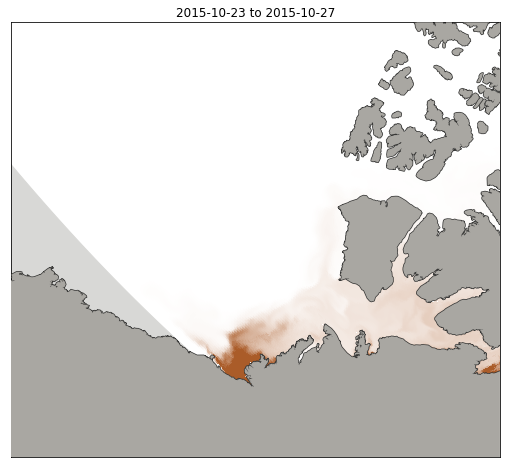

In [19]:
fig, ax1 = plt.subplots(1,1, figsize=(10,8))

ani = animation.FuncAnimation(fig, animate_full, frames=72*3, interval=200)
ani
ani.save('/ocean/brogalla/GEOTRACES/MK-extent-2016-2019.mp4', dpi=300, fps=14)